# Import File

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
from svgfig import *
import sys
import getopt
import glob
import cv2
import numpy as np

# A. Generate Chessboard
   ### Class::PatternMaker

In [2]:
class PatternMaker:
    def __init__(self, cols, rows, output, units, square_size, radius_rate, page_width, page_height):
        self.cols = cols
        self.rows = rows
        self.output = output
        self.units = units
        self.square_size = square_size
        self.radius_rate = radius_rate
        self.width = page_width
        self.height = page_height
        self.g = SVG("g")  # the svg group container
    def makeCheckerboardPattern(self):
        spacing = self.square_size
        xspacing = (self.width - self.cols * self.square_size) / 2.0
        yspacing = (self.height - self.rows * self.square_size) / 2.0
        for x in range(0, self.cols):
            for y in range(0, self.rows):
                if x % 2 == y % 2:
                    square = SVG("rect", x=x * spacing + xspacing, y=y * spacing + yspacing, width=spacing,
                                 height=spacing, fill="black", stroke="none")
                    self.g.append(square)

### Class::PatternsMaker  output

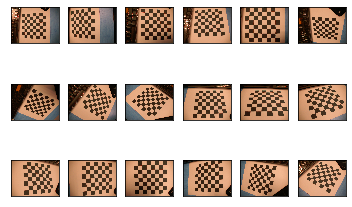

In [17]:
imgsList = glob.glob('./images/*.jpg')
fig = plt.figure()
for i in range(1,19):
    img = cv2.imread(imgsList[i])
    a = fig.add_subplot(3, 6, i)
    a.axes.get_xaxis().set_visible(False)
    a.axes.get_yaxis().set_visible(False)
    plt.imshow(img)


# B. CameraCalibration
### Class::CameraCalibration

In [74]:
class CameraCalibration():
    def __init__(self, rows,cols,imgsList=[]):
        self.rows = rows
        self.cols = cols
        self.imgsList = imgsList
    
    @staticmethod
    def find_chressboard_corners(grayImg, rows, cols):
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
        ret, corners = cv2.findChessboardCorners(grayImg, (cols, rows), None)
        if not ret:
            return []
        corners_refine = cv2.cornerSubPix(grayImg, corners, (11, 11), (-1, -1), criteria)
            
        return corners_refine
        
    def single_cam_calibration(self):
        objp = np.zeros((self.rows * self.cols, 3), np.float32)
        objp[:, :2] = np.mgrid[0:self.cols, 0:self.rows].T.reshape(-1, 2)

        objpoints = []  # 3d point in real world space
        imgpoints = []  # 2d points in image plane.

        gray_shape = None
        for fname in self.imgsList:
            img = cv2.imread(fname)
            grayImg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            gray_shape = grayImg.shape            
            objpoints.append(objp)
            imgpoints.append(CameraCalibration.find_chressboard_corners(grayImg,self.rows,self.cols))

        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray_shape[::-1], None, None)
        return mtx

In [75]:
CameraCalibration(7,7,imgsList).single_cam_calibration()

array([[4.53154619e+03, 0.00000000e+00, 2.00211114e+03],
       [0.00000000e+00, 4.53513282e+03, 1.57575959e+03],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

# C. Estimated distance

In [92]:
def get_width(corners):
    minVal, maxVal = np.float('inf'), np.float('-inf')
    for i in range(len(corners)):
        minVal = min(corners[i][0][0], minVal)
        maxVal = max(corners[i][0][0], maxVal)
    return maxVal - minVal if maxVal - minVal >= 0 else -1

def cal_distance(width):
    return (4531.5*120)/width

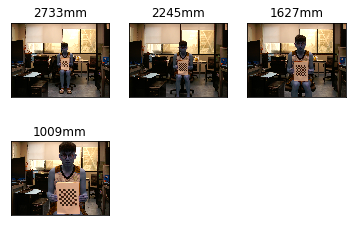

In [97]:
testImgs = glob.glob('./test/*.jpg')
fig = plt.figure()
for i in range(4):
    img = cv2.imread(testImgs[i], cv2.COLOR_BGR2GRAY)
    grayImg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    corners = CameraCalibration.find_chressboard_corners(grayImg, 7,7)
    
    distance = cal_distance(get_width(corners))
    
    a = fig.add_subplot(2, 3, i+1)
    a.axes.get_xaxis().set_visible(False)
    a.axes.get_yaxis().set_visible(False)
    a.set_title(str(int(distance))+'mm')
    plt.imshow(img)

# example of main

In [4]:
def main():
    # parse command line options, TODO use argparse for better doc
    try:
        opts, args = getopt.getopt(sys.argv[1:], "Ho:c:r:T:u:s:R:w:h:a:", ["help", "output=", "columns=", "rows=",
                                                                           "type=", "units=", "square_size=",
                                                                           "radius_rate=",
                                                                           "page_width=", "page_height=", "page_size="])
    except getopt.error as msg:
        print(msg)
        print("for help use --help")
        sys.exit(2)
    pm = deserilized_opts()
    # dict for easy lookup of pattern type
    mp = {"circles": pm.makeCirclesPattern, "acircles": pm.makeACirclesPattern,
          "checkerboard": pm.makeCheckerboardPattern}
    mp[p_type](opts)
    # this should save pattern to output
    pm.save()